# Machine Learning LAB 4: Soft SVM

Course 2024/25: *F. Chiariotti*

The notebook contains a simple learning task over which we will implement a **SOFT SUPPORT VECTOR MACHINE**.

Complete all the **required code sections**.

### IMPORTANT for the exam:

The functions you might be required to implement in the exam will have the same signature and parameters as the ones in the labs

## Classification of Stayed/Churned Customers

The Customer Churn table contains information on all 3,758 customers from a Telecommunications company in California in Q2 2022. Companies are naturally interested in churn, i.e., in which users are likely to switch to another company soon to get a better deal, and which are more loyal customers.

The dataset contains three features:
- **Tenure in Months**: Number of months the customer has stayed with the company
- **Monthly Charge**: The amount charged to the customer monthly
- **Age**: Customer's age

The aim of the task is to predict if a customer will churn or not based on the three features.

---

## Import all the necessary Python libraries and load the dataset

### The Dataset
The dataset is a `.csv` file containing three input features and a label. Here is an example of the first 4 rows of the dataset: 

<center>

Tenure in Months | Monthly Charge | Age | Customer Status |
| -----------------| ---------------|-----|-----------------|
| 9 | 65.6 | 37 | 0 |
| 9 | -4.0 | 46 | 0 |
| 4 | 73.9 | 50 | 1 |
| ... | ... | ... | ... |

</center>

Customer Status is 0 if the customer has stayed with the company and 1 if the customer has churned.

In [1]:
import numpy as np
import pandas as pd
import random as rnd
from matplotlib import pyplot as plt
from sklearn import linear_model, preprocessing
from sklearn.model_selection import train_test_split

np.random.seed(1)

def load_dataset(filename):
    data_train = pd.read_csv(filename)
    #permute the data
    data_train = data_train.sample(frac=1).reset_index(drop=True) # shuffle the data
    X = data_train.iloc[:, 0:3].values # Get first two columns as the input
    Y = data_train.iloc[:, 3].values # Get the third column as the label
    Y = 2*Y-1 # Make sure labels are -1 or 1 (0 --> -1, 1 --> 1)
    return X,Y

# Load the dataset
X, Y = load_dataset('data/telecom_customer_churn_cleaned.csv')

We are going to differentiate (classify) between **class "1" (churned)** and **class "-1" (stayed)**

## Divide the data into training and test sets

In [2]:
# Compute the splits
m_training = int(0.75*X.shape[0])

# m_test is the number of samples in the test set (total-training)
m_test =  X.shape[0] - m_training
X_training =  X[:m_training]
Y_training =  Y[:m_training]
X_test =   X[m_training:]
Y_test =  Y[m_training:]

print("Number of samples in the train set:", X_training.shape[0])
print("Number of samples in the test set:", X_test.shape[0])
print("Number of churned users in test:", np.sum(Y_test==-1))
print("Number of loyal users in test:", np.sum(Y_test==1))

# Standardize the input matrix
# The transformation is computed on training data and then used on all the 3 sets
scaler = preprocessing.StandardScaler().fit(X_training) 

np.set_printoptions(suppress=True) # sets to zero floating point numbers < min_float_eps
X_training =  scaler.transform(X_training)
print ("Mean of the training input data:", X_training.mean(axis=0))
print ("Std of the training input data:",X_training.std(axis=0))

X_test =  scaler.transform(X_test)
print ("Mean of the test input data:", X_test.mean(axis=0))
print ("Std of the test input data:", X_test.std(axis=0))

Number of samples in the train set: 2817
Number of samples in the test set: 940
Number of churned users in test: 479
Number of loyal users in test: 461
Mean of the training input data: [-0.  0. -0.]
Std of the training input data: [1. 1. 1.]
Mean of the test input data: [0.0575483  0.05550169 0.0073833 ]
Std of the test input data: [0.98593187 0.97629659 1.00427583]


We will use **homogeneous coordinates** to describe all the coefficients of the model.

_Hint:_ The conversion can be performed with the function $hstack$ in $numpy$.

In [3]:
def to_homogeneous(X_training, X_test):
    Xh_training = np.hstack([np.ones( (X_training.shape[0], 1) ), X_training])
    Xh_test = np.hstack([np.ones( (X_test.shape[0], 1) ), X_test])
    return Xh_training, Xh_test

In [4]:
# convert to homogeneous coordinates using the function above
X_training, X_test = to_homogeneous(X_training, X_test)
print("Training set in homogeneous coordinates:")
print(X_training[:10])

Training set in homogeneous coordinates:
[[ 1.         -0.3798618  -1.57020044  0.85174963]
 [ 1.         -0.87925308  0.47180292  1.08667766]
 [ 1.         -0.75440526 -0.6130632  -0.26415851]
 [ 1.         -1.12894873  0.09856916 -0.96894261]
 [ 1.         -1.12894873 -0.58486332 -1.20387064]
 [ 1.          1.78416712  1.39908145  0.08823353]
 [ 1.         -0.7960212  -1.0990965  -0.32289052]
 [ 1.          0.20276137 -0.39907585 -0.96894261]
 [ 1.         -0.62955744  0.63934341  0.96921364]
 [ 1.         -0.87925308  1.13201197 -0.02923048]]


## Soft SVM with stochastic gradient descent

Now **complete** the function *sgd_soft_svm* and all auxiliary functions. <br>
You should select *a single sample*, compute the gradient, and run the soft SVM version (.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the soft SVM
- $averaging\_iterations$: the number of iterations to consider when averaging

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $margin$: the *margin* of the best model
- $outliers$: the number of outliers that are classified correctly by the best model
- $misclassified$: the number of outliers that are misclassified by the best model

In [5]:
def count_outliers(current_w, X, Y):
    # Return a tuple containing 2 numbers:
    # First, the number of total outliers (distance below the margin)
    # Second, the number of misclassified outliers
    products = np.dot(X, current_w) * Y
    total_outliers = np.sum(np.where(products > 1, 0, 1))
    missclassified_outliers = np.sum(np.where(products > 0, 0, 1))
    return (total_outliers, missclassified_outliers)

def find_margin(current_w):  
    # Return the margin for the selected model
    return 1/np.linalg.norm(current_w)

def sgd_soft_svm(X, Y, lambda_par, max_num_iterations, averaging_iterations):
    # Initialize the weights of the algorith with w=0
    theta = np.zeros(X.shape[1])
    best_w = np.zeros(X.shape[1])
    num_samples = X.shape[0]

    # Loop the SGD algorithm
    for num_iter in range(max_num_iterations):
        # Compute the current weights
        w = theta * ( 1. /(lambda_par * (num_iter + 1)) )
        # Compute the gradient over a random point
        i = np.random.choice(np.arange(num_samples), size = 1)[0]
        hinge_loss = np.max(1 - np.dot(X[i, :], w)*Y[i], 0)
        if hinge_loss > 0:
            theta = theta + X[i, :]*Y[i]
        if (num_iter >= max_num_iterations - averaging_iterations):
            # Use the current model for averaging
            best_w += w
    best_w /= averaging_iterations
    margin = find_margin(best_w)
    (outliers, misclassified) = count_outliers(best_w, X, Y)
    return best_w, margin, outliers, misclassified

Now we use the implementation to learn a model from the training data using 100000 iterations and averaging over the last 10000. Let us consider $\lambda=1$. Then we use the best model $best\_w$ to **predict the labels for the test dataset** and print the fraction of outliers in the test set (the test error that is an estimate of the true loss).

In [12]:
# Now run the Soft SVM with lambda=0.1. Consider 100000 iterations, 10000 of which are avera
best_w, margin, outliers, misclassified = sgd_soft_svm(X_training, Y_training, 0.1, int(1e5), int(1e4))
print("Soft SVM model: " + str(best_w))
print("Soft SVM margin: " + str(margin))
print("Total outliers: " + str(outliers))
print("Misclassified points: " + str(misclassified))
true_error = np.asarray(count_outliers(best_w, X_test, Y_test)) / len(Y_test)

print("Total outlier fraction (test set): " + str(true_error[0]))
print("True loss (test set): " + str(true_error[1]))

Soft SVM model: [ 0.02553251 -0.90289938  0.40600127  0.14433671]
Soft SVM margin: 0.999226235182756
Total outliers: 1943
Misclassified points: 732
Total outlier fraction (test set): 0.7085106382978723
True loss (test set): 0.2553191489361702


Now let us compare the result with your perceptron function from Lab 2.

In [7]:
def perceptron_randomized_update(current_w, X, Y):
    # TODO: write the perceptron update function
    (n, index) = count_errors(current_w, X, Y)
    if n > 0:
        i = np.random.choice(index, size = 1)[0]
        current_w += X[i, :] * Y[i]
    return current_w

def count_errors(current_w, X, Y):
    # Find all indices which have a different sign from the corresponding labels
    index = np.nonzero(np.sign(np.dot(X, current_w)) - Y)[0]
    n = np.array(index).shape[0]
    if (n == 0):
        # There are no misclassified samples
        return 0, -1
    return (n, index)

def perceptron_with_randomization(X, Y, max_num_iterations):
    # TODO: write the perceptron main loop
    # The perceptron should run for up to max_num_iterations, or stop if it finds a solution with ERM=0
    num_samples = X.shape[0]
    best_w = np.zeros(X.shape[1])
    current_w = np.zeros(X.shape[1])
    best_error = 10e9
    n_iter = 0
    while( best_error > 0 and n_iter < max_num_iterations):
        n_iter += 1
        current_w = perceptron_randomized_update(current_w, X, Y)
        (n, _) = count_errors(current_w, X, Y)
        current_error = n/num_samples
        if current_error < best_error:
            best_error = current_error
            best_w = current_w
    return best_w, best_error

Let us test the error of the Soft SVM against the perceptron's best model, using 1000 iterations.

In [8]:
w_found, error = perceptron_with_randomization(X_training, Y_training, 1000)
print("Training Error of perceptron: " + str(error))
print("Best perceptron model: " + str(w_found))
true_loss_estimate =  count_errors(w_found, X_test, Y_test)[0] / len(Y_test)    # Error rate on the test set    
print("Test Error of perceptron: " + str(true_loss_estimate))

Training Error of perceptron: 0.2463613773517927
Best perceptron model: [-2.         -2.48631978  1.14816202 -0.70505513]
Test Error of perceptron: 0.33085106382978724


Now we can try to see the effect of $\lambda$. Consider values $10, 1, 0.1, 0.01, 0.001$ and run a K-fold cross validation (you can use the code from Lab 3). Plot the margin and outlier count. Use the loss (i.e., the number of misclassified points) as a score.

In [14]:
def K_fold(X_training: np.ndarray, Y_training: np.ndarray, lambda_vec: np.ndarray, K: np.ndarray) -> None:
    ## TODO: perform cross-validation
    # Divide training set in K folds
    #fold_points = int(np.floor(max_idx / K))
    shuffled_idxs = np.arange(X_training.shape[0])
    np.random.shuffle(shuffled_idxs)
    X_shuffled, Y_shuffled = X_training[shuffled_idxs], Y_training[shuffled_idxs]
    validation_fold_idxs = np.array_split(shuffled_idxs, K)
    training_fold_idxs = [np.setdiff1d(shuffled_idxs, fold_idxs) for fold_idxs in validation_fold_idxs]
    xt_folds, yt_folds = [X_training[fold] for fold in training_fold_idxs], [Y_training[fold] for fold in training_fold_idxs]
    xv_folds, yv_folds = [X_training[fold] for fold in validation_fold_idxs], [Y_training[fold] for fold in validation_fold_idxs]
    results = []
    models = []
    best_perf = 10e9
    best = np.zeros(X_shuffled.shape[1])
    for lambda_idx in range(len(lambda_vec)):
        lambda_perf = 0
        for i in range(K):
            # Cross-validation step
            best_w, _, _, _ = sgd_soft_svm(xt_folds[i], yt_folds[i], lambda_vec[lambda_idx], int(1e5), int(1e4))
            _, misclassified = count_outliers(best_w, xv_folds[i], yv_folds[i])
            lambda_perf = misclassified / xv_folds[i].shape[0]
        results.append(lambda_perf)
        models.append(sgd_soft_svm(X_shuffled, Y_shuffled, lambda_vec[lambda_idx], int(1e5), int(1e4)))
        if (best_perf > lambda_perf):
            # Improvement on the model
            best_perf = lambda_perf
            best = sgd_soft_svm(X_shuffled, Y_shuffled, lambda_vec[lambda_idx], int(1e5), int(1e4))
    return best, best_perf, models, results

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/var/folders/vk/kftm8379123bsmwrdp8l0xr00000gn/T/ipykernel_5731/495028130.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\log(\lambda)$')


(array([-0.06634601, -1.19805651,  0.65942972,  0.20897567]), np.float64(0.7220151541795479), np.int64(1598), np.int64(694)) [np.float64(0.25044404973357015), np.float64(0.25754884547069273), np.float64(0.2557726465364121), np.float64(0.23801065719360567), np.float64(0.2291296625222025)]


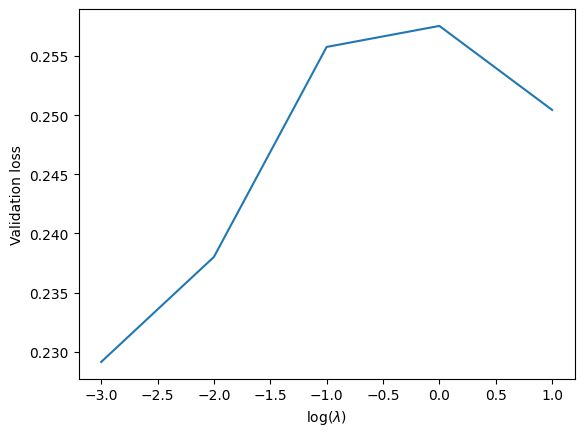

In [15]:
# Run the training with K-fold cross-validation and plot the score
K = 5
lambda_par = [10, 1, 1e-1, 1e-2, 1e-3]

best_model, best_perf, models, results = K_fold(X_training, Y_training, lambda_par, K)
print(best_model, results)
plt.plot(np.log10(lambda_par), results)
plt.xlabel('$\log(\lambda)$')
plt.ylabel('Validation loss')
plt.show()

What does this tell you about the margins? Which one should you choose? Now compute the test loss of the best Soft SVM. What does this tell you about the algorithm choice over this problem?

In [16]:
true_error = np.asarray(count_outliers(best_model[0], X_test, Y_test)) / len(Y_test)
print("Total outlier fraction (test set): " + str(true_error[0]))
print("True loss (test set): " + str(true_error[1]))

Total outlier fraction (test set): 0.5776595744680851
True loss (test set): 0.24468085106382978
